In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 7: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[7])

import random
import string
from collections import defaultdict
from itertools import product, chain
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import logging
import os
import sys

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaDoubleHeadsModel, RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3  # XD

logging.basicConfig(level=logging.ERROR)

In [40]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1} {rel_suffix}"
B_template = "{pred_prefix} {dt} {ent} {pred}"
entailment_templates = ["{A} ? {conj} , {B} .", "{A} , so {B} ? {conj} ."]

markers = {'lexical': '*', 'entity': '#'}

def extract_rel_id(s): return int(s[s.index(':') + 1])
def extract_rel(s): return [t.split(':')[0] for t in s.split() if ':' in t][0]
def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
tag2id = {'same': 0, 'opposite': 1, 'unrelated': 2, 'former': 3, 'latter': 4, 'another': 5, 'single': 6, 'paired': 7}
tag2id = {'Ġ' + k: v for k, v in tag2id.items()}
id2tag = {v: k for k, v in tag2id.items()}

def make_sentences(index=-1, entities=["_X", "_Z"], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[["big",], ["small"]], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=None, entity_relations=None, tag_lexical_rel=False, tag_entity_rel=False):
    if tag_lexical_rel: mask_types.add('lexical_rel')
    if tag_entity_rel: mask_types.add('entity_rel')  
    def get_comparative(word):
        compar = comparative(word)
        if tag_lexical_rel:
            marker = markers['lexical']
            compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
        return compar
  
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, 
                                  rel_prefix=relation_prefix, rel_suffix=relation_suffix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]

    def form_sentences(sentence_template, As, Bs, conj):
        def compare_and_tag_comparative(A, B):
            if 'Maybe' in conj:
                lexical_rel = 'unrelated'
            else:
                lexical_rel = 'same' if extract_rel_id(A) == extract_rel_id(B) else 'opposite'
            if lexical_relations and lexical_rel not in lexical_relations:
                return None, None
            if 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
            return strip_rel_id(A), strip_rel_id(B, lexical_rel)
#             triple = '%s %s %s' % (extract_rel(A), lexical_rel, extract_rel(B))
#             return strip_rel_id(A), strip_rel_id(B), triple
        def tag_entity(token, recurred_entity, entity_rel=None):
            if token != recurred_entity: return token
            return markers['entity'] + ' ' + token
#             if token not in entities: return token
#             entity_rel = 'paired' if token == recurred_entity else 'single'
#             if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
#             return token + ' ( %s )' % entity_rel
            
        def compare_and_tag_entity(A, B):
            recurred_entity = [e for e in entities if e in B.split()][0]
            A = ' '.join([tag_entity(token, recurred_entity) for token in A.split()])
            B = ' '.join([tag_entity(token, recurred_entity) for token in B.split()])
            entity_rel = 'former' if A.split().index(recurred_entity) in [0, 1] else 'latter'
            if entity_relations and entity_rel not in entity_relations: return None, None
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            return A, B #.replace(recurred_entity, recurred_entity + ' ( ' + entity_rel + ' )')
#             triple = '%s %s %s' % (recurred_entity, entity_rel, recurred_entity)
#             return A, B, triple
        
        if 'sent_rel' in mask_types: conj = mask(conj)
        sentences = []
        for A, B in product(As, Bs):
            A, B = compare_and_tag_comparative(A, B) \
                if tag_lexical_rel else (strip_rel_id(A), strip_rel_id(B))
            if A is None: continue
#             entity_triple = None
            if tag_entity_rel: A, B = compare_and_tag_entity(A, B)
            if A is None: continue
            sent = sentence_template.format(A=A, B=B, conj=conj)
#             triples = ' , '.join([t for t in [entity_triple, lexical_triple] if t is not None])
#             if triples: sent = sent + ' Hint : ' + triples
#             sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences

    sentences = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), (negAs, Bs['rand'], 'Maybe')]:
            sentences[conj] += form_sentences(entailment_template, A, B, conj)
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    if has_neutral:
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)
    
    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1 = random.sample(entity_set, 2)
            sent_group.append(sent.replace(entities[0], e0).replace(entities[1], e1))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

make_sentences(has_negA=True, has_negB=True, has_neutral=False, tag_lexical_rel=False, tag_entity_rel=True,
               mask_types={'sent_rel'}, entity_relations=['former'])[0]

['# _Z is smaller than _X , so # _Z is smaller ? [ Right ] .',
 '# _Z is smaller than _X , so # _Z is not bigger ? [ Right ] .',
 '# _X is bigger than _Z , so # _X is bigger ? [ Right ] .',
 '# _X is bigger than _Z , so # _X is not smaller ? [ Right ] .',
 '# _Z is not smaller than _X , so # _Z is not smaller ? [ Right ] .',
 '# _Z is not smaller than _X , so # _Z is bigger ? [ Right ] .',
 '# _X is not bigger than _Z , so # _X is not bigger ? [ Right ] .',
 '# _X is not bigger than _Z , so # _X is smaller ? [ Right ] .',
 '# _Z is smaller than _X , so # _Z is not smaller ? [ Wrong ] .',
 '# _Z is smaller than _X , so # _Z is bigger ? [ Wrong ] .',
 '# _X is bigger than _Z , so # _X is not bigger ? [ Wrong ] .',
 '# _X is bigger than _Z , so # _X is smaller ? [ Wrong ] .',
 '# _Z is not smaller than _X , so # _Z is smaller ? [ Wrong ] .',
 '# _Z is not smaller than _X , so # _Z is not bigger ? [ Wrong ] .',
 '# _X is not bigger than _Z , so # _X is bigger ? [ Wrong ] .',
 '# _X is not 

In [125]:
def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase,
                    relation_group=[["confident", ], ["uncertain", ]], n_entity_trials=3,
                    has_negP=True, has_negQ=True, has_neutral=False, mask_types=['sent_rel']):
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                 [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_rels = [negate_sent(r)[0] for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                      [entities + reverse(neg_rels)[:1], reverse(entities) + neg_rels[:1]]]
        return atoms

    def form_sentences(transitive_template, Ps, Qs, conj):
        sentences = []
        if 'sent_rel' in mask_types: conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = transitive_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1),
                                              Q=strip_rel_id(Q), conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences

    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = [" is %s:%d than" % (comparative(rel), i)
                             for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]

        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences

    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], len(sentences[key]) // sample_ratio)
#     print('nRight =', len(sentences['Right']))
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)

    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0)
                              .replace(entities[1], e1)
                              .replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

make_transitive(has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[0]

[' _X is more confident than _Y and _Y is more confident than _Z , so _X is more confident than _Z ? [ Right ] .',
 ' _X is more confident than _Y and _Y is more confident than _Z , so _Z is more uncertain than _X ? [ Right ] .',
 ' _X is more confident than _Y and _Y is more confident than _Z , so _X is less uncertain than _Z ? [ Right ] .',
 ' _X is more confident than _Y and _Y is more confident than _Z , so _Z is less confident than _X ? [ Right ] .',
 ' _X is more confident than _Y and _Z is more uncertain than _Y , so _X is more confident than _Z ? [ Right ] .',
 ' _X is more confident than _Y and _Z is more uncertain than _Y , so _Z is more uncertain than _X ? [ Right ] .',
 ' _X is more confident than _Y and _Z is more uncertain than _Y , so _X is less uncertain than _Z ? [ Right ] .',
 ' _X is more confident than _Y and _Z is more uncertain than _Y , so _Z is less confident than _X ? [ Right ] .',
 ' _X is more confident than _Y and _Y is less uncertain than _Z , so _X is more

In [7]:
tokenizer_class, shortcut = RobertaTokenizer, 'roberta-base'
tokenizer = tokenizer_class.from_pretrained(shortcut)

In [154]:
# rand_relation_group=_frames[(i + 1) % len(_frames)], 
# random.seed(42)
# random.shuffle(frames)
# entity_set = list(string.ascii_uppercase)
# random.shuffle(entity_set)
split_pct = [0.7, 0.3]

n_entity_trials = 3
kwargs = {'n_entity_trials': n_entity_trials, 'has_neutral': False, 'has_negA': True, 'has_negB': True, 
          'tag_lexical_rel': False, 'tag_entity_rel': False, 'mask_types':{'sent_rel',}, 'entity_relations': ['former', ]}
train_lines, eval_lines = [[make_sentences(relation_group=rg, entity_set=_ent_set, **kwargs)[1] for i, rg in enumerate(_frames)]
                           for _frames, _ent_set in zip(split(frames, split_pct), split(entity_set, split_pct))]
# all_lines = [make_sentences(relation_group=rg, rand_relation_group=frames[(i + 1) % len(frames)], 
#                             n_entity_trials=n_entity_trials, has_neutral=False,
#                             has_negA=True, has_negB=True, tag_lexical_rel=False, tag_entity_rel=False,
#                             mask_types={'sent_rel',}, entity_relations=['former', ])[1]
#              for i, rg in enumerate(frames)]
# all_lines = [make_transitive(relation_group=rg, n_entity_trials=n_entity_trials,
#                              has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]
#              for i, rg in enumerate(frames)]
# all_lines = join_lists(all_lines)
# all_lines = join_lists(all_lines)
# tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
# for k in CHILDDataset.all_lines: CHILDDataset.all_lines[k] = None
kwargs = {'markers': None, 'max_noise_len': 0, 'n_replicas': 1, 'split_pct': [0.7, 0.3, 0.0]}
train_dataset = CHILDDataset(train_lines, tokenizer, mode='train', **kwargs)
eval_dataset = CHILDDataset(eval_lines, tokenizer, mode='dev', **kwargs)
# train_dataset, eval_dataset = [CHILDDataset(_lines, tokenizer, mode=mode, **kwargs) 
#                                for _lines, mode in zip([train_lines, eval_lines], ['train', 'dev'])]
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))

nTrain = 10608, nValid = 4128


In [155]:
# model_class, model = RobertaForMaskedLM, None
# # model_class, model = RobertaDoubleHeadsModel3, None
# model = model_class.from_pretrained('roberta-base', model=model)
steps = max(int(round(100 * n_entity_trials / 3)), int(len(train_dataset) / 32 / 4))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=32, per_device_eval_batch_size=64,
    learning_rate=2e-5, num_train_epochs=3,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
model.tokenizer = tokenizer
trainer.train()

{'loss': 0.494441, 'learning_rate': 1.7991967871485944e-05, 'epoch': 0.301, 'step': 100}



{'eval_loss': 0.331483, 'eval_acc_0': 0.887, 'eval_stat_0': 'ĠRight 0.53 0.95, ĠWrong 0.47 0.92, ', 'epoch': 0.301, 'step': 100}
{'loss': 0.15644, 'learning_rate': 1.5983935742971887e-05, 'epoch': 0.602, 'step': 200}



{'eval_loss': 0.271215, 'eval_acc_0': 0.956, 'eval_stat_0': 'ĠRight 0.51 0.99, ĠWrong 0.49 0.99, ', 'epoch': 0.602, 'step': 200}
{'loss': 0.062766, 'learning_rate': 1.3975903614457833e-05, 'epoch': 0.904, 'step': 300}



{'eval_loss': 0.854337, 'eval_acc_0': 0.938, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 0.904, 'step': 300}



{'loss': 0.034302, 'learning_rate': 1.1967871485943776e-05, 'epoch': 1.205, 'step': 400}



{'eval_loss': 1.072325, 'eval_acc_0': 0.919, 'eval_stat_0': 'ĠRight 0.49 1.00, ĠWrong 0.51 1.00, ', 'epoch': 1.205, 'step': 400}
{'loss': 0.013694, 'learning_rate': 9.959839357429719e-06, 'epoch': 1.506, 'step': 500}



{'eval_loss': 0.964351, 'eval_acc_0': 0.935, 'eval_stat_0': 'ĠRight 0.49 1.00, ĠWrong 0.51 1.00, ', 'epoch': 1.506, 'step': 500}
{'loss': 0.013991, 'learning_rate': 7.951807228915663e-06, 'epoch': 1.807, 'step': 600}



{'eval_loss': 0.761857, 'eval_acc_0': 0.952, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 1.807, 'step': 600}



{'loss': 0.011654, 'learning_rate': 5.943775100401607e-06, 'epoch': 2.108, 'step': 700}



{'eval_loss': 0.483392, 'eval_acc_0': 0.963, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 2.108, 'step': 700}
{'loss': 0.004868, 'learning_rate': 3.93574297188755e-06, 'epoch': 2.41, 'step': 800}



{'eval_loss': 0.878321, 'eval_acc_0': 0.942, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 2.41, 'step': 800}
{'loss': 0.000687, 'learning_rate': 1.9277108433734943e-06, 'epoch': 2.711, 'step': 900}



{'eval_loss': 0.94726, 'eval_acc_0': 0.94, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 2.711, 'step': 900}





{'eval_loss': 0.91416, 'eval_acc_0': 0.942, 'eval_stat_0': 'ĠRight 0.50 1.00, ĠWrong 0.50 1.00, ', 'epoch': 3.0, 'step': 996}


TrainOutput(global_step=996, training_loss=0.07976772980278275)

In [182]:
output_dir = '/nas/xd/data/models/CHILD/pred_all_rels/'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)

In [80]:
model.roberta.selectively_masked_head = (5, 5)

In [91]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=trainer.args.eval_batch_size,
    collate_fn=trainer.data_collator,
    drop_last=trainer.args.dataloader_drop_last,
)

In [92]:
for inputs in dataloader: break

for i in range(20):
    print(i, tokenizer.decode(inputs['input_ids'][i])) #, 
#           [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['head_mask'][i]])

0 <s> F is more willing than E,</s> so E (<mask> ) is more voluntary (<mask> )?<mask>.</s><s><s><s><s>
1 <s> Q is more frivolous than G,</s> so G (<mask> ) is less serious (<mask> )?<mask>.</s><s><s><s><s>
2 <s> D is less willing than B,</s> so B (<mask> ) is more willing (<mask> )?<mask>.</s><s><s><s><s>
3 <s> L is more illegal than F,</s> so F (<mask> ) is less illegal (<mask> )?<mask>.</s><s><s><s><s>
4 <s> A is more distant than E,</s> so A (<mask> ) is not closer (<mask> )?<mask>.</s><s><s><s><s>
5 <s> Y is less competent than U,</s> so Y (<mask> ) is more competent (<mask> )?<mask>.</s><s><s><s><s>
6 <s> O is more distant than H,</s> so O (<mask> ) is not nearer (<mask> )?<mask>.</s><s><s><s><s>
7 <s> B is faster than S,</s> so B (<mask> ) is faster (<mask> )?<mask>.</s><s><s><s><s><s><s>
8 <s> D is further than E,</s> so E (<mask> ) is further (<mask> )?<mask>.</s><s><s><s><s><s><s>
9 <s> Z is darker than Q,</s> so Q (<mask> ) is brighter (<mask> )?<mask>.</s><s><s><s><s><s><s>


In [140]:
marked_pos_labels = inputs['marked_pos_labels']
marked_pos_labels.size()

torch.Size([64, 2, 2])

In [128]:
holoattn = torch.cat(attn_probs, dim=1)
holoattn.size()

torch.Size([64, 144, 28, 28])

In [129]:
marked_holoattn = holoattn[torch.arange(64).unsqueeze(-1), :, marked_pos_labels[:, :, 0], marked_pos_labels[:, :, 1]]
marked_holoattn.size()

torch.Size([64, 2, 144])

In [131]:
marked_hidden = last_hidden_states[((inputs['input_ids'] == tokenizer.mask_token_id) * (inputs['labels'] == -100))].view(64, -1, 768)
marked_hidden.size()

torch.Size([64, 2, 768])

In [119]:
last_hidden_states = all_hidden_states[-1]

In [157]:
_ = model.eval()
interpretable_embedding = configure_interpretable_embedding_layer(model, 'roberta.embeddings')

inputs = trainer._prepare_inputs(inputs, model)
input_ids, token_type_ids, position_ids, attention_mask, labels = \
    inputs['input_ids'], inputs['token_type_ids'], inputs['position_ids'], inputs['attention_mask'], inputs['labels']
input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
all_tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(input_ids[0]))

/nas/xd/projects/captum/captum/attr/_models/base.py:189: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  "In order to make embedding layers more interpretable they will "


In [164]:
mask_id = 0
layer_attrs = []
for i in range(model.config.num_hidden_layers):
    lc = LayerIntegratedGradients(mlm_fwd_fn, model.roberta.encoder.layer[i])
    attributions = lc.attribute(inputs=input_embeddings, 
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, labels, mask_id), 
                                n_steps=20)[0]
    layer_attrs.append(summarize_attributions(attributions).cpu().detach().tolist())

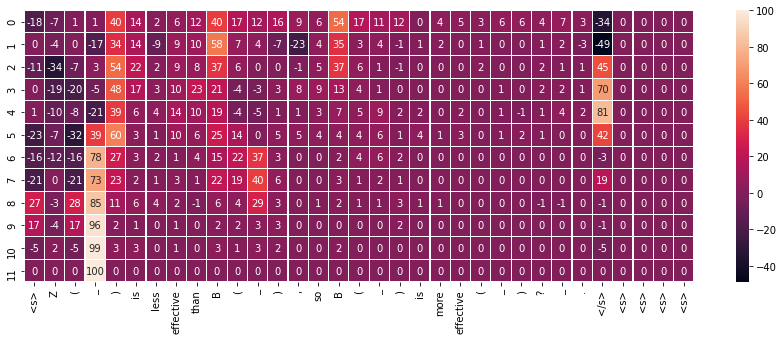

In [165]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(model.config.num_hidden_layers))
ax = sns.heatmap((np.array(layer_attrs) * 100).astype('int64'), xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='d', linewidth=0.2)
# plt.xlabel('Tokens')
# plt.ylabel('Layers')
plt.show()

In [171]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

In [127]:
_ = model.eval()
inputs = trainer._prepare_inputs(inputs, model)
with torch.no_grad():
    loss, logits, all_hidden_states, all_attentions = model(**inputs, output_hidden_states=True, output_attentions=True)

attn_scores, attn_probs = zip(*all_attentions)
# attn_scores, attn_probs = torch.stack(attn_scores, dim=0), torch.stack(attn_probs, dim=0)
# attn_probs = attn_probs.cpu()

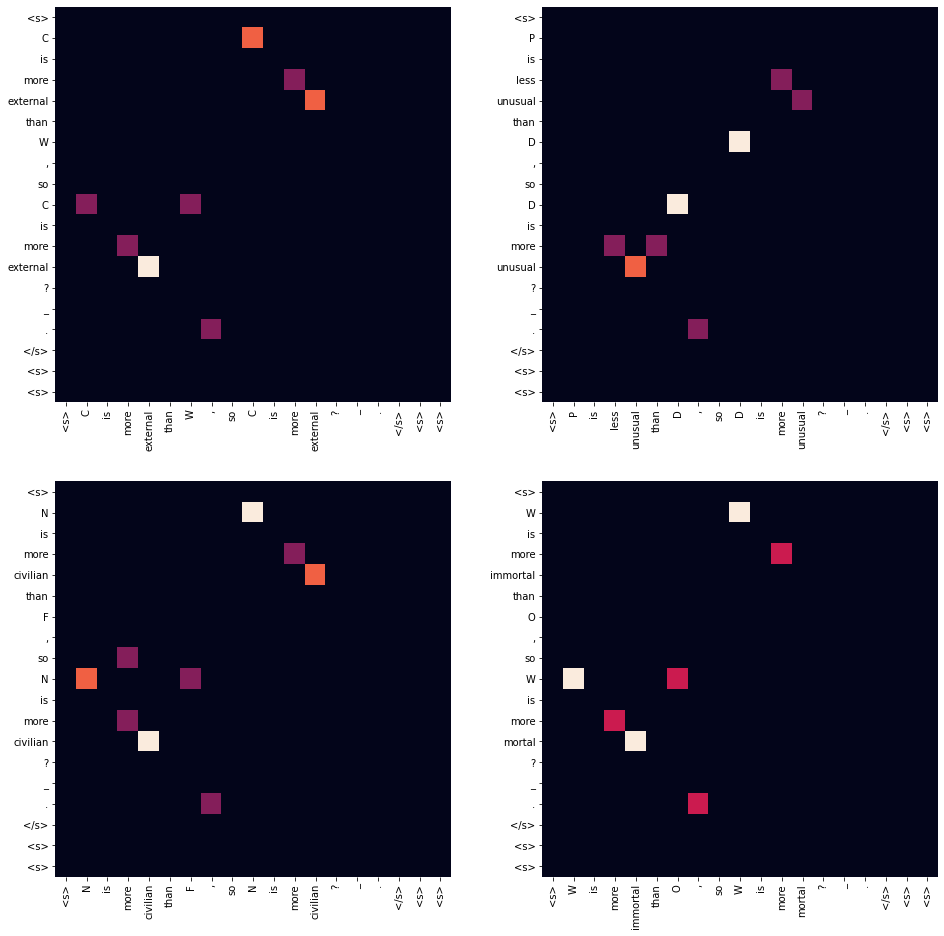

In [81]:
sample_indices = [[0, 1], 
                  [2, 3]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * 2 * n_cols, 4 * 2 * n_rows))
sep_id = tokenizer._convert_token_to_id('Ġ,')
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        
        pos_attn = attn_probs[:, i]
        pos_attn = pos_attn * (pos_attn > 0.3)
#         pos_attn[0] = 0  # layer 0
#         pos_attn[1, 1] = 0  # ->pos-2
        pos_attn = pos_attn.mean(dim=(0, 1))
        input_ids = inputs['input_ids'][i]
        sep_pos = (input_ids == sep_id).nonzero()[0].item()
        segment_ids = torch.zeros_like(input_ids)
        segment_ids[sep_pos + 1:] = 1
        segment_mask = segment_ids.unsqueeze(0) != segment_ids.unsqueeze(1)
        pos_attn = pos_attn * segment_mask.cpu()
        seq_len = inputs['attention_mask'][i].sum().item()
        pos_attn[:, [0, 2, seq_len - 1]] = 0
        k = torch.arange(1, pos_attn.size(0) - 1)
        pos_attn[k, k] = 0
        pos_attn[k, k - 1] = 0
        pos_attn[k, k + 1] = 0
        ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', 
                         xticklabels=tokens, yticklabels=tokens, ax=ax)
        
#         p, h = inputs['head_mask'][i]
#         p, h = p.item(), h.item()
#         h = h - 4
#         p = p - 1
#         pos_attn = attn_probs[:, i, :, h, p]
#         pos_attn[-1, -1] = 1.
#         ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=True, fmt='d', ax=ax)
#         ax.tick_params(top=True, labeltop=True)
#         _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

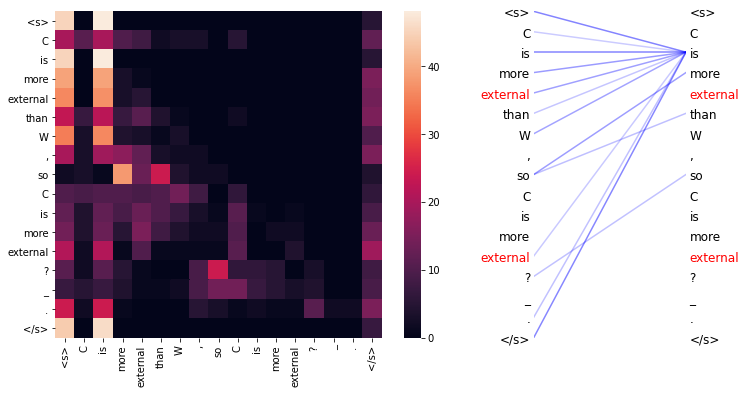

In [78]:
i = 0
layer, head = 6, 10
seq_len = inputs['attention_mask'][i].sum().item()
attn =  attn_probs[layer, i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long(), square=True, cbar=True, annot=False, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['head_mask'][i])